In [1]:
import os, sys
import ROOT

Welcome to JupyROOT 6.26/10


# Reading the input histograms into a dictionary

In [2]:
prod_modes = ['LL', 'LN', 'NN']

indict = {
    "VLLS":{
        "ele":{
            "M100":{},
            "M125":{},
            "M150":{},
            "M200":{},
            "M250":{},
            "M300":{},
            "M350":{},
            "M400":{},
            "M450":{},
            "M500":{},
            "M750":{},
            "M1000":{}
        },
        "mu":{
            "M100":{},
            "M125":{},
            "M150":{},
            "M200":{},
            "M250":{},
            "M300":{}, #350 is missing
            "M400":{},
            "M450":{},
            "M500":{},
            "M750":{},
            "M1000":{}
        }
    },
    "VLLD":{
        "ele":{
            "M100":{},
            "M200":{},
            "M300":{},
            "M400":{},
            "M600":{},
            "M800":{},
            "M1000":{},
            "M1200":{},
            "M1400":{},
            "M1600":{},
            "M1800":{},
            "M2000":{},
            "M2200":{}
        },
        "mu":{
            "M100":{},
            "M200":{},
            "M300":{},
            "M400":{},
            "M600":{},
            "M800":{}, #1000 is missing
            "M1200":{},
            "M1400":{},
            "M1600":{},
            "M1800":{},
            "M2000":{},
            "M2200":{}
        }
    }
}

for model, flavors in indict.items():
    for flav, masses in flavors.items():
        for mass, parameters in masses.items():
            filename = f'../input_files/hst_{model}_{flav}_{mass}.root'
            file_exists = os.path.exists(filename)
            if file_exists:
                #Read the information from the hists:
                tfile = ROOT.TFile(filename)
                for mode in prod_modes:
                    hist = tfile.Get(f'finalstates_for_{mode}')
                    #acc_2L, acc_3L, acc_4L = 0, 0 ,0
                    evtall   = hist.GetBinContent(1)
                    evt_1L0J = hist.GetBinContent(2)
                    evt_1L1J = hist.GetBinContent(3)
                    evt_1L2J = hist.GetBinContent(4)
                    evt_2LSS = hist.GetBinContent(5)
                    evt_2LOS = hist.GetBinContent(6)
                    evt_3L   = hist.GetBinContent(7)
                    evt_4L   = hist.GetBinContent(8)
                    parameters[f"{mode}_all"]  = evtall
                    parameters[f"{mode}_1L0J"] = evt_1L0J
                    parameters[f"{mode}_1L1J"] = evt_1L1J
                    parameters[f"{mode}_1L2J"] = evt_1L2J
                    parameters[f"{mode}_2LOS"] = evt_2LOS
                    parameters[f"{mode}_2LSS"] = evt_2LSS
                    parameters[f"{mode}_3L"]   = evt_3L
                    parameters[f"{mode}_4L"]   = evt_4L
                    
print('Dictionary ready!')

Dictionary ready!


# Setting up the plot makers

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import os  # Don't forget to import os
datestamp = datetime.today().strftime('%Y-%m-%d')
plotdir = 'plots/'+datestamp
os.system(f'mkdir -p {plotdir}')

def acceptance(num, den):
    if den == 0:
        return 0
    else:
        return (num / den) * 100
    
#plotting style:
thin_line = {
    'marker':'o',
    'linestyle':'--',
    'markersize':4,
    'linewidth':1
}
thick_line = {
    'marker':'o',
    'linestyle':'-',
    'markersize':6,
    'linewidth':2
}

production_modes = ['LL', 'LN', 'NN']
final_states = ['1L0J', '1L1J', '1L2J', '2LOS', '2LSS', '3L', '4L']

def make_plot(model, flav):
    data = indict[model][flav]
    
    mass_points = [int(point.replace('M', '')) for point in data.keys()]

    fig, axs = plt.subplots(1, len(production_modes), figsize=(15, 5), sharey=True)
    
    for i, mode in enumerate(production_modes):
        acceptance_1L0J = []
        acceptance_1L1J = []
        acceptance_1L2J = []
        acceptance_2LOS = []
        acceptance_2LSS = []
        acceptance_3L   = []
        acceptance_4L   = []
        acceptance_lep  = []
        acceptance_all  = []
        
        for mass in mass_points:
            n1L0J = data[f'M{mass}'][f'{mode}_1L0J']
            n1L1J = data[f'M{mass}'][f'{mode}_1L1J']
            n1L2J = data[f'M{mass}'][f'{mode}_1L2J']
            n2LOS = data[f'M{mass}'][f'{mode}_2LOS']
            n2LSS = data[f'M{mass}'][f'{mode}_2LSS']
            n3L   = data[f'M{mass}'][f'{mode}_3L']
            n4L   = data[f'M{mass}'][f'{mode}_4L']
            nlep  = n2LOS + n2LSS + n3L + n4L
            ncomb = n1L0J + n1L1J + n1L2J + nlep
            nall  = data[f'M{mass}'][f'{mode}_all']
            
            acceptance_1L0J.append(acceptance(n1L0J, nall))
            acceptance_1L1J.append(acceptance(n1L1J, nall))
            acceptance_1L2J.append(acceptance(n1L2J, nall))
            acceptance_2LOS.append(acceptance(n2LOS, nall))
            acceptance_2LSS.append(acceptance(n2LSS, nall))
            acceptance_3L.append(acceptance(n3L, nall))
            acceptance_4L.append(acceptance(n4L, nall))
            acceptance_lep.append(acceptance(nlep, nall))
            acceptance_all.append(acceptance(ncomb, nall))
        
        # Plot the acceptance for 2L, 3L, and 4L for the current production mode
        axs[i].plot(mass_points, acceptance_1L0J, **thin_line, color='yellow', label=f'1L0J')
        axs[i].plot(mass_points, acceptance_1L1J, **thin_line, color='gold',   label=f'1L1J')
        axs[i].plot(mass_points, acceptance_1L2J, **thin_line, color='orange', label=f'1L2J-incl')
        axs[i].plot(mass_points, acceptance_2LOS, **thin_line, color='b',      label=f'2LOS')
        axs[i].plot(mass_points, acceptance_2LSS, **thin_line, color='c',      label=f'2LSS')
        axs[i].plot(mass_points, acceptance_3L,   **thin_line, color='g',      label=f'3L')
        axs[i].plot(mass_points, acceptance_4L,   **thin_line, color='r',      label=f'4L-incl')
        axs[i].plot(mass_points, acceptance_lep, **thick_line, color='gray',   label=f'Multilep')
        axs[i].plot(mass_points, acceptance_all, **thick_line, color='black',  label=f'Combined')
        axs[i].set_title(f'{model} {flav} - {mode} Production Mode', fontsize=14)
        axs[i].set_xlabel('Mass (GeV)', fontsize=12)
        axs[i].set_ylabel('Acceptance (%)', fontsize=12)
        axs[i].set_ylim(0, 100)  # Set y-axis range from 0 to 100
        axs[i].grid(True)
        axs[i].legend(loc='upper right')
    
    # Set a common y-axis label
    axs[0].set_ylabel('Acceptance (%)', fontsize=12)

    # Adjust spacing between subplots with horizontal spacing
    plt.tight_layout(w_pad=3.0)  # Adjust w_pad as needed for spacing
    plt.savefig(f'{plotdir}/acceptance_{model}_{flav}.png', dpi=300)
    plt.show()

def make_combined_plot(model, flav):
    data = indict[model][flav]
    
    mass_points = [int(point.replace('M', '')) for point in data.keys()]

    acceptance_1L0J = []
    acceptance_1L1J = []
    acceptance_1L2J = []
    acceptance_2LOS = []
    acceptance_2LSS = []
    acceptance_3L   = []
    acceptance_4L   = []
    acceptance_lep  = []
    acceptance_all  = []
    
    for mass in mass_points:
        total_1L0J = sum(data[f'M{mass}'][f'{mode}_1L0J'] for mode in production_modes)
        total_1L1J = sum(data[f'M{mass}'][f'{mode}_1L1J'] for mode in production_modes)
        total_1L2J = sum(data[f'M{mass}'][f'{mode}_1L2J'] for mode in production_modes)
        total_2LOS = sum(data[f'M{mass}'][f'{mode}_2LOS'] for mode in production_modes)
        total_2LSS = sum(data[f'M{mass}'][f'{mode}_2LSS'] for mode in production_modes)
        total_3L   = sum(data[f'M{mass}'][f'{mode}_3L']   for mode in production_modes)
        total_4L   = sum(data[f'M{mass}'][f'{mode}_4L']   for mode in production_modes)
        total_all  = sum(data[f'M{mass}'][f'{mode}_all']  for mode in production_modes)
        
        acceptance_1L0J.append(acceptance(total_1L0J, total_all))
        acceptance_1L1J.append(acceptance(total_1L1J, total_all))
        acceptance_1L2J.append(acceptance(total_1L2J, total_all))
        acceptance_2LOS.append(acceptance(total_2LOS, total_all))
        acceptance_2LSS.append(acceptance(total_2LSS, total_all))
        acceptance_3L.append(acceptance(total_3L, total_all))
        acceptance_4L.append(acceptance(total_4L, total_all))
        acceptance_lep.append(acceptance((total_2LOS+total_2LSS+total_3L+total_4L), total_all))
        acceptance_all.append(acceptance((total_1L0J+total_1L1J+total_1L2J+total_2LOS+total_2LSS+total_3L+total_4L), total_all))
    
    plt.figure(figsize=(5, 5))
    plt.plot(mass_points, acceptance_1L0J, **thin_line, color='yellow', label='1L0J')
    plt.plot(mass_points, acceptance_1L1J, **thin_line, color='gold', label='1L1J')
    plt.plot(mass_points, acceptance_1L2J, **thin_line, color='orange', label='1L2J-incl')
    plt.plot(mass_points, acceptance_2LOS, **thin_line, color='b', label='2LOS')
    plt.plot(mass_points, acceptance_2LSS, **thin_line, color='c', label='2LSS')
    plt.plot(mass_points, acceptance_3L,   **thin_line, color='g', label='3L')
    plt.plot(mass_points, acceptance_4L,   **thin_line, color='r', label='4L-incl')
    plt.plot(mass_points, acceptance_lep, **thick_line, color='gray', label='Multilep')
    plt.plot(mass_points, acceptance_all, **thick_line, color='black', label='Combined')
    
    plt.title(f'{model} {flav}', fontsize=14)
    plt.xlabel('Mass (GeV)', fontsize=12)
    plt.ylabel('Acceptance (%)', fontsize=12)
    plt.ylim(0, 100)  # Set y-axis range from 0 to 100
    plt.grid(True)
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig(f'{plotdir}/acceptance_{model}_{flav}_combined.png', dpi=300)
    plt.show()

print('Functions loaded!')


Functions loaded!


# Plotting for different models

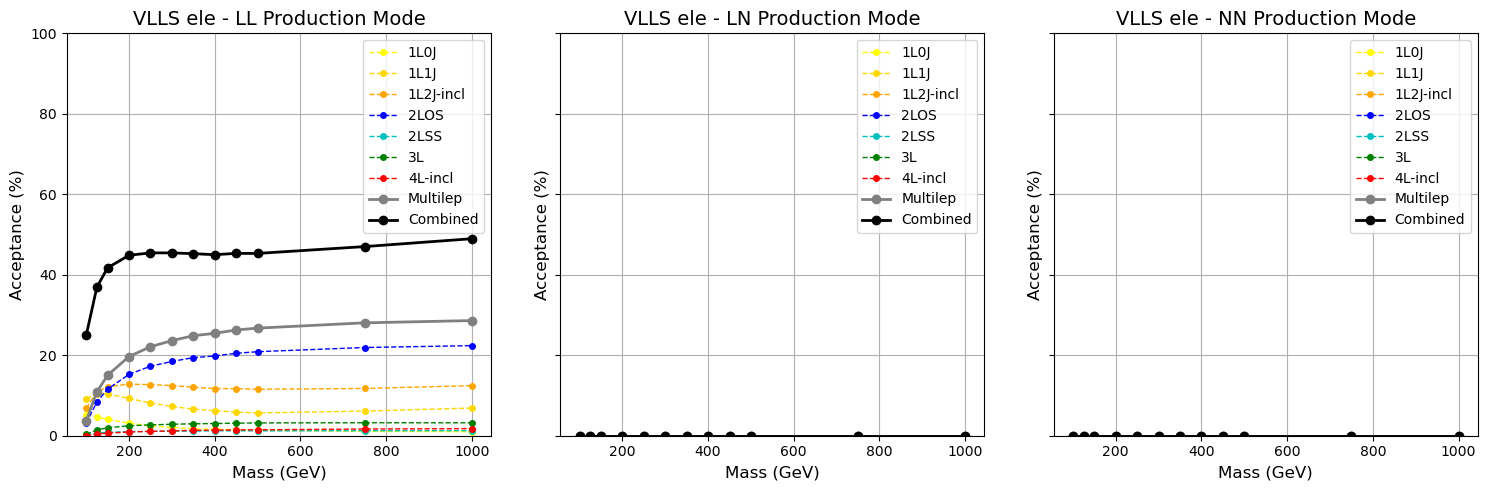

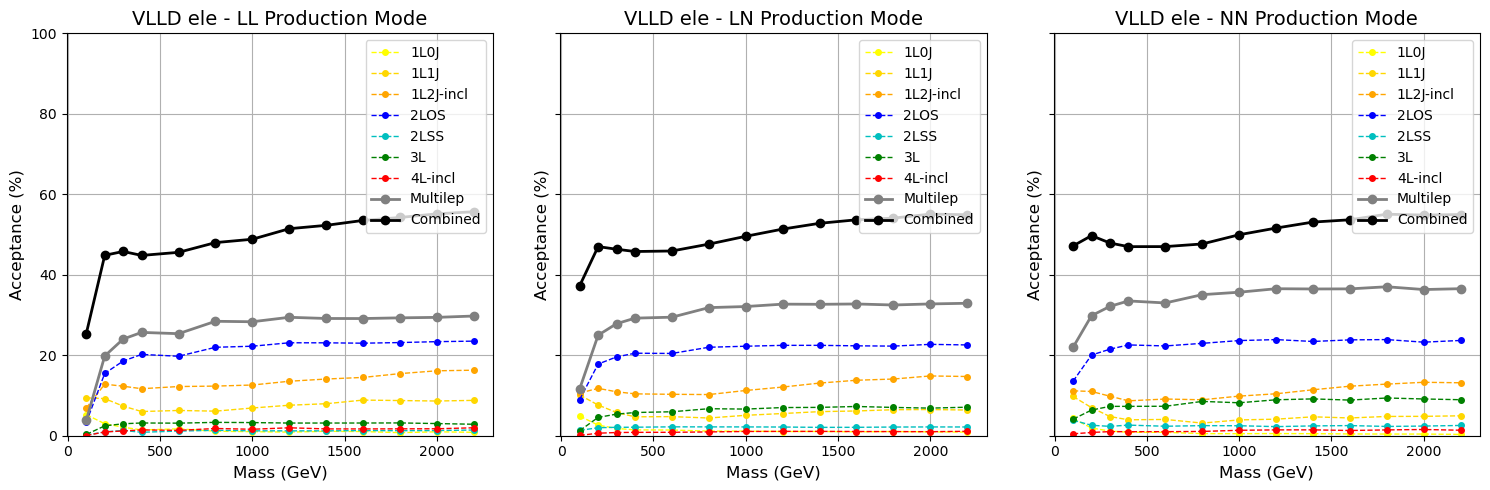

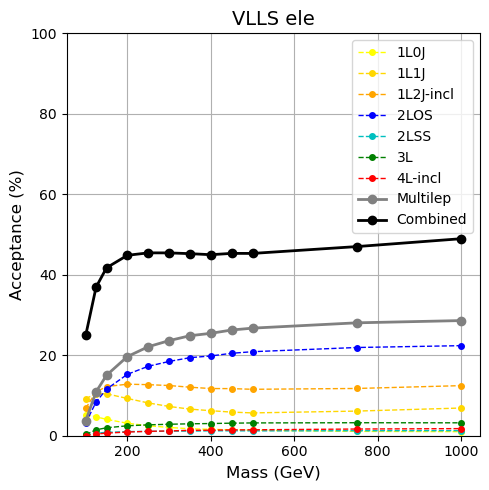

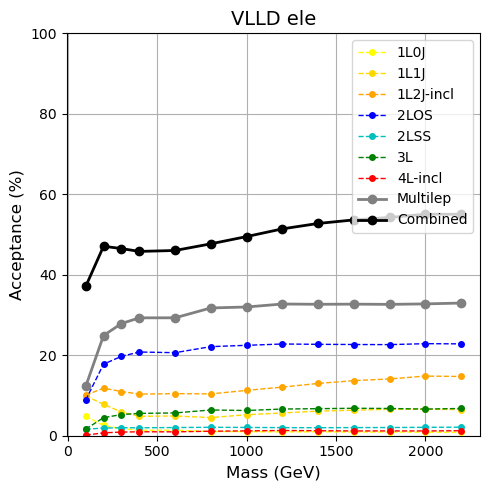

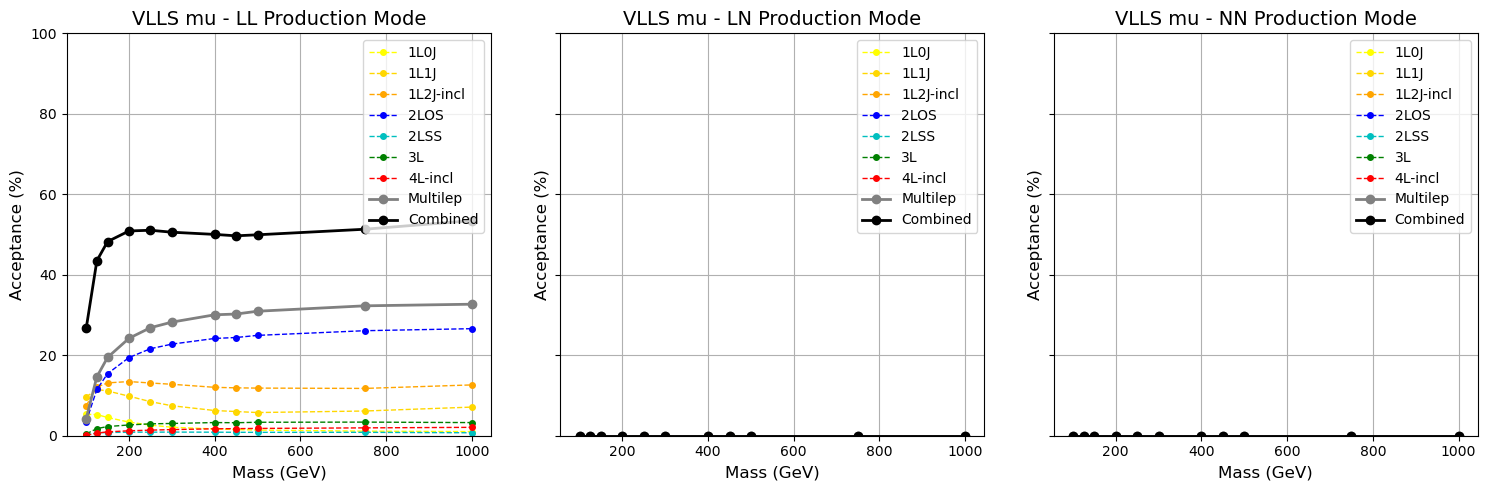

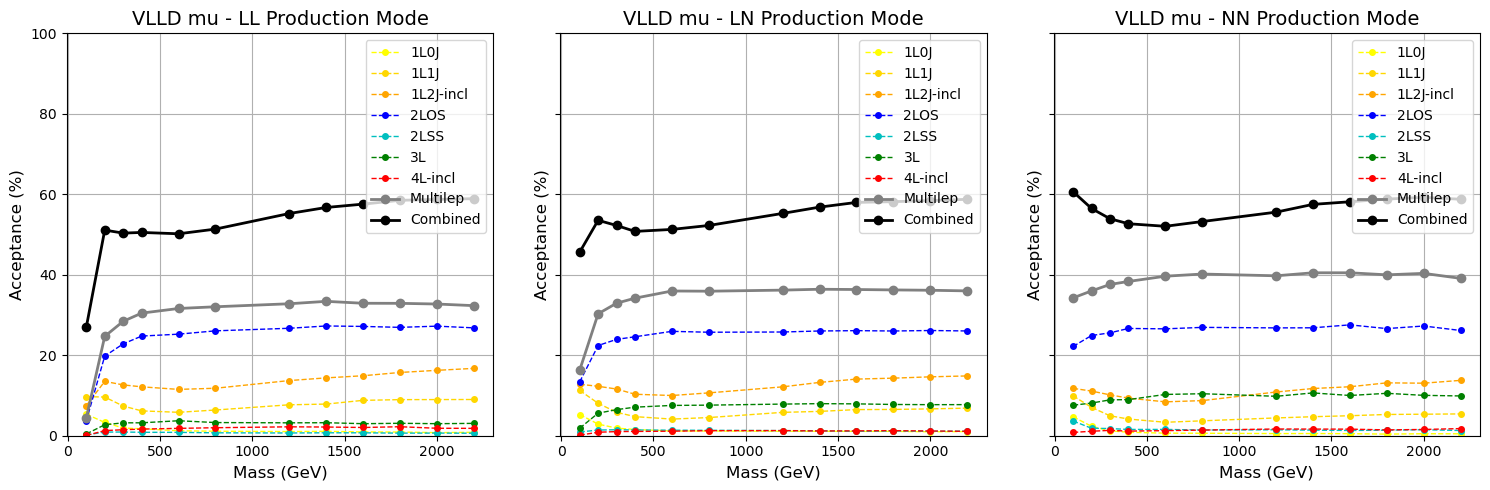

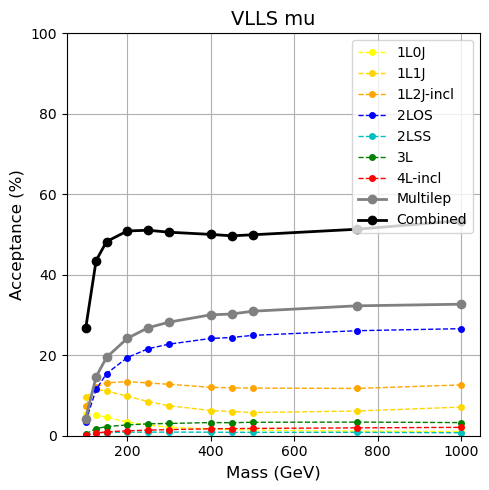

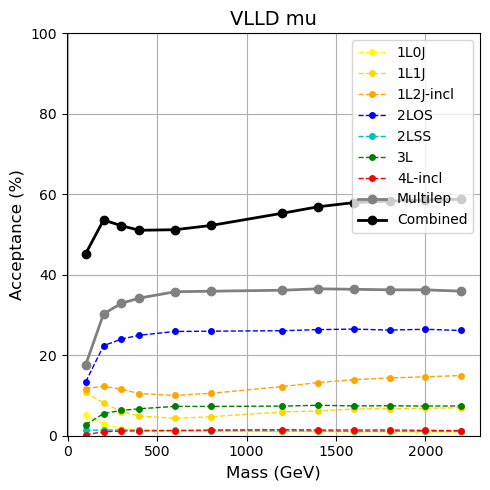

Done!


In [4]:
# Call the function
make_plot('VLLS', 'ele')
make_plot('VLLD', 'ele')
make_combined_plot('VLLS', 'ele')
make_combined_plot('VLLD', 'ele')
make_plot('VLLS', 'mu')
make_plot('VLLD', 'mu')
make_combined_plot('VLLS', 'mu')
make_combined_plot('VLLD', 'mu')

print('Done!')

# Printing out the numbers

In [5]:
def print_info(model_, flav_):
    print('-'*50)
    print(f'For the {model_}_{flav_} model,')
    print('-'*50)
    print('Mass\tAllevents\t1L0J\t1L1J\t1L2J\t2LOS\t2LSS\t3L\t4L')
    for model, flavors in indict.items():
        for flav, masses in flavors.items():
            for mass, parameters in masses.items():
                if model==model_ and flav==flav_ :
                    nall  = int(sum(parameters[f'{mode}_all']  for mode in production_modes))
                    n1L0J = int(sum(parameters[f'{mode}_1L0J'] for mode in production_modes))
                    n1L1J = int(sum(parameters[f'{mode}_1L1J'] for mode in production_modes))
                    n1L2J = int(sum(parameters[f'{mode}_1L2J'] for mode in production_modes))
                    n2LOS = int(sum(parameters[f'{mode}_2LOS'] for mode in production_modes))
                    n2LSS = int(sum(parameters[f'{mode}_2LSS'] for mode in production_modes))
                    n3L   = int(sum(parameters[f'{mode}_3L']   for mode in production_modes))
                    n4L   = int(sum(parameters[f'{mode}_4L']   for mode in production_modes))
                    print(f'{mass}\t{nall}\t\t{n1L0J}\t{n1L1J}\t{n1L2J}\t{n2LOS}\t{n2LSS}\t{n3L}\t{n4L}')
    print('\n')
                        
print_info('VLLS', 'ele')
print_info('VLLS', 'mu')
print_info('VLLD', 'ele')
print_info('VLLD', 'mu')

--------------------------------------------------
For the VLLS_ele model,
--------------------------------------------------
Mass	Allevents	1L0J	1L1J	1L2J	2LOS	2LSS	3L	4L
M100	599740		31270	55237	40900	18868	1037	1891	199
M125	594714		27912	62070	64762	49901	3818	8755	2412
M150	598626		24356	62416	73093	69306	5003	11825	3826
M200	598182		18536	55392	76615	91289	6096	14766	5520
M250	496991		12354	40499	63069	85773	5322	13446	5382
M300	498516		10251	36265	62183	92027	5627	14205	5953
M350	199194		3441	13166	24016	38642	2293	5900	2669
M400	199048		3178	12379	23338	39454	2423	6031	2744
M450	194893		2862	11438	22816	39925	2375	6080	2820
M500	197776		2690	11212	22820	41298	2381	6291	2909
M750	99165		1073	6070	11646	21741	1231	3201	1650
M1000	98973		1004	6812	12320	22151	1247	3175	1748


--------------------------------------------------
For the VLLS_mu model,
--------------------------------------------------
Mass	Allevents	1L0J	1L1J	1L2J	2LOS	2LSS	3L	4L
M100	594746		31597	57450	44357	20892	